# Building a perceptron-based linear regressor

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

num_points = 1200

data = []
m = 0.2
c = 0.5
for i in range(num_points):
  x = np.random.normal(0.0, 0.8)

noise = np.random.normal(0.0, 0.04)

y = m*x + c + noise
data.append([x, y])

x_data = [d[0] for d in data]
y_data = [d[1] for d in data]

plt.plot(x_data, y_data, 'ro')
plt.title('Input data')
plt.show()

W = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
b = tf.Variable(tf.zeros([1]))

y = W * x_data + b
loss = tf.reduce_mean(tf.square(y - y_data))

optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(loss)

init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

num_iterations = 10
for step in range(num_iterations):
  sess.run(train)

print('\nITERATION', step+1)
print('W =', sess.run(W)[0])
print('b =', sess.run(b)[0])
print('loss =', sess.run(loss))


plt.plot(x_data, y_data, 'ro')
plt.plot(x_data, sess.run(W) * x_data + sess.run(b))
plt.xlabel('Dimension 0')
plt.ylabel('Dimension 1')
plt.title('Iteration ' + str(step+1) + ' of ' + str(num_iterations))
plt.show()

# Building an image classifier using a single layer neural network

In [0]:
import argparse
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

def build_arg_parser():
  parser = argparse.ArgumentParser(description='Build a classifier using\MNIST data')
  parser.add_argument('--input-dir', dest='input_dir', type=str, default='./mnist_data', help='Directory for storing data')
  return parser

if __name__ == '__main__':
  args = build_arg_parser().parse_args()

  mnist = input_data.read_data_sets(args.input_dir, one_hot=True)
  
  x = tf.placeholder(tf.float32, [None, 784])
  
  W = tf.Variable(tf.zeros([784, 10]))
  b = tf.Variable(tf.zeros([10]))
  
  y = tf.matmul(x, W) + b
  y_loss = tf.placeholder(tf.float32, [None, 10])
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_loss))
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  init = tf.initialize_all_variables()
  session = tf.Session()
  session.run(init)
  num_iterations = 1200
  batch_size = 90
  for _ in range(num_iterations):
    x_batch, y_batch = mnist.train.next_batch(batch_size)
    session.run(optimizer, feed_dict = {x: x_batch, y_loss: y_batch})
  predicted = tf.equal(tf.argmax(y, 1), tf.argmax(y_loss, 1))
  accuracy = tf.reduce_mean(tf.cast(predicted, tf.float32))
  print('\nAccuracy =', session.run(accuracy, feed_dict = {x: mnist.test.images, y_loss: mnist.test.labels}))

# Building an image classifier using a Convolutional Neural Network

In [0]:
import argparse
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data


def build_arg_parser():
  parser = argparse.ArgumentParser(description='Build a CNN classifier using \MNIST data')
  parser.add_argument('--input-dir', dest='input_dir', type=str, default='./mnist_data', help='Directory for storing data')
  return parser

def get_weights(shape):
  data = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(data)

def get_biases(shape):
  data = tf.constant(0.1, shape=shape)
  return tf.Variable(data)

def create_layer(shape):
  W = get_weights(shape)
  b = get_biases([shape[-1]])
  return W, b

def convolution_2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pooling(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

if __name__ == '__main__':
  args = build_arg_parser().parse_args()
  mnist = input_data.read_data_sets(args.input_dir, one_hot=True)
  x = tf.placeholder(tf.float32, [None, 784])
  x_image = tf.reshape(x, [-1, 28, 28, 1])
  W_conv1, b_conv1 = create_layer([5, 5, 1, 32])
  h_conv1 = tf.nn.relu(convolution_2d(x_image, W_conv1) + b_conv1)
  h_pool1 = max_pooling(h_conv1)
  W_conv2, b_conv2 = create_layer([5, 5, 32, 64])
  h_conv2 = tf.nn.relu(convolution_2d(h_pool1, W_conv2) + b_conv2)
  h_pool2 = max_pooling(h_conv2)
  W_fc1, b_fc1 = create_layer([7 * 7 * 64, 1024])
  h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
  h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
  keep_prob = tf.placeholder(tf.float32)
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
  W_fc2, b_fc2 = create_layer([1024, 10])
  y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
  y_loss = tf.placeholder(tf.float32, [None, 10])
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_loss))
  optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)
  predicted = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_loss, 1))
  accuracy = tf.reduce_mean(tf.cast(predicted, tf.float32))
  sess = tf.InteractiveSession()
  init = tf.initialize_all_variables()
  sess.run(init)
  num_iterations = 21000
  batch_size = 75
  print('\nTraining the model....')
  for i in range(num_iterations):
    batch = mnist.train.next_batch(batch_size)
    if i % 50 == 0:
      cur_accuracy = accuracy.eval(feed_dict = {x: batch[0], y_loss: batch[1], keep_prob: 1.0})
      print('Iteration', i, ', Accuracy =', cur_accuracy)
  optimizer.run(feed_dict = {x: batch[0], y_loss: batch[1], keep_prob: 0.5})
  print('Test accuracy =', accuracy.eval(feed_dict = {x: mnist.test.images, y_loss: mnist.test.labels, keep_prob: 1.0}))


# CNN on CIFAR10 Dataset

In [25]:
import keras
from keras.models import Sequential
from keras.datasets import cifar10
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adadelta
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils.vis_utils import model_to_dot, plot_model
from keras import backend as K
import numpy as np
from IPython.display import SVG
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
np.random.seed(2017)
batch_size = 256
nb_classes = 10
nb_epoch = 4
nb_filter = 10
nb_conv = 3
nb_pool = 2
img_rows, img_cols = 32, 32
img_channels = 3

if K.image_data_format() == 'th':
 input_shape = (3, img_rows, img_cols)
else:
 input_shape = (img_rows, img_cols, 3)
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

feature_layers = [Convolution2D(nb_filter, nb_conv, nb_conv, input_shape=input_shape),
 Activation('relu'),
 Convolution2D(nb_filter, nb_conv, nb_conv),
 Activation('relu'),
 MaxPooling2D(pool_size=(nb_pool, nb_pool)),
 Flatten(),]
classification_layers = [
 Dense(512),
 Activation('relu'),
 Dense(nb_classes),
 Activation('softmax')]

model = Sequential(feature_layers + classification_layers)
model.compile(loss='categorical_crossentropy', optimizer="adadelta",
metrics=['accuracy'])
# print(model.summary())

model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,validation_data=(X_test, Y_test))

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (3, 3), input_shape=(32, 32, 3...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.




Train on 50000 samples, validate on 10000 samples
Epoch 1/4





50000/50000 [==============================] - 50s 1ms/step - loss: 1.8607 - acc: 0.3374 - val_loss: 1.6290 - val_acc: 0.4239
Epoch 2/4
50000/50000 [==============================] - 50s 992us/step - loss: 1.4244 - acc: 0.4994 - val_loss: 1.3904 - val_acc: 0.5042
Epoch 3/4
50000/50000 [==============================] - 50s 999us/step - loss: 1.2397 - acc: 0.5617 - val_loss: 1.2992 - val_acc: 0.5305
Epoch 4/4
50000/50000 [==============================] - 50s 996us/step - loss: 1.1164 - acc: 0.6088 - val_loss: 1.2009 - val_acc: 0.5714


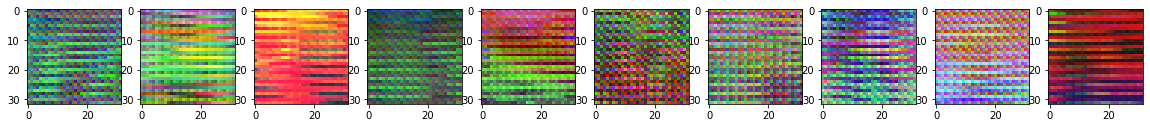

In [26]:
def draw(data, row, col, n):
  plt.subplot(row, col, n)
  plt.imshow(data)

show_size = 10
plt.figure(figsize=(20,20))
for i in range(show_size):
  draw(X_train[i].reshape(3, 32, 32).transpose(1, 2, 0), 1, show_size, i+1)
plt.show()

In [27]:
get_first_layer_output = K.function([model.layers[0].input], [model.
layers[1].output])
first_layer = get_first_layer_output([X_train[0:show_size]])[0]
plt.figure(figsize=(20,20))

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [0]:
for img_index, filters in enumerate(first_layer, start=1):
  for filter_index, mat in enumerate(filters):
    pos = (filter_index)*show_size+img_index
    draw(mat, nb_filter, show_size, pos)
plt.show()

In [0]:
get_second_layer_output = K.function([model.layers[0].input], [model.layers[3].output])
second_layers = get_second_layer_output([X_train[0:show_size]])[0]
plt.figure(figsize=(20,20))
for img_index, filters in enumerate(second_layers, start=1):
  for filter_index, mat in enumerate(filters):
    pos = (filter_index)*show_size+img_index
    draw(mat, nb_filter, show_size, pos)
plt.show()

In [0]:
get_third_layer_output = K.function([model.layers[0].input], [model.layers[4].output])
third_layers = get_third_layer_output([X_train[0:show_size]])[0]
plt.figure(figsize=(20,20))
for img_index, filters in enumerate(third_layers, start=1):
  for filter_index, mat in enumerate(filters):
    pos = (filter_index)*show_size+img_index
    mat_size = mat.shape[1]
    draw(mat, nb_filter, show_size, pos)
plt.show()

# CNN on MNIST Dataset

In [43]:
import keras
keras.backend.backend()
keras.backend.image_data_format()
K = keras.backend.backend()
if K=='tensorflow':
 keras.backend.tensorflow_backend.set_image_dim_ordering('tf')
else:
 keras.backend.tensorflow_backend.  set_image_dim_ordering('th')
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(2017)
from keras import backend as K
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Activation, Convolution2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras import backend as K
from keras.utils.vis_utils import plot_model
from IPython.display import SVG, display
img_rows, img_cols = 28, 28
nb_classes = 10
nb_filters = 5 # the number of filters
nb_pool = 2 # window size of pooling
nb_conv = 3 # window or kernel size of filter
nb_epoch = 5
# image dimension based on backend. ‘th’ = theano and ‘tf’ = tensorflow
if K.image_data_format() == 'th':
 input_shape = (1, img_rows, img_cols)
else:
 input_shape = (img_rows, img_cols, 1)
# data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


In [46]:
feature_layers = [
 Convolution2D(nb_filters, nb_conv, nb_conv, input_shape=input_shape),
 Activation('relu'),
 Convolution2D(nb_filters, nb_conv, nb_conv),
 Activation('relu'),
 MaxPooling2D(pool_size=(nb_pool, nb_pool)),
 Dropout(0.25),
 Flatten(),
]
classification_layers = [
 Dense(128),
 Activation('relu'),
 Dropout(0.5),
 Dense(nb_classes),
 Activation('softmax')
]
model = Sequential(feature_layers + classification_layers)
feature_layers = [
 Convolution2D(nb_filters, nb_conv, nb_conv, input_shape=input_shape),
 Activation('relu'),
 Convolution2D(nb_filters, nb_conv, nb_conv),
 Activation('relu'),
 MaxPooling2D(pool_size=(nb_pool, nb_pool)),
 Dropout(0.25),
 Flatten(),
]

classification_layers = [
 Dense(128),
 Activation('relu'),
 Dropout(0.5),
 Dense(nb_classes),
 Activation('softmax')
]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(5, (3, 3), input_shape=(28, 28, 1...)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(5, (3, 3))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(5, (3, 3), input_shape=(28, 28, 1...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(5, (3, 3))`


In [47]:
model = Sequential(feature_layers + classification_layers)
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 26, 26, 5)         50        
_________________________________________________________________
activation_33 (Activation)   (None, 26, 26, 5)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 5)         230       
_________________________________________________________________
activation_34 (Activation)   (None, 24, 24, 5)         0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 5)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 12, 12, 5)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 720)              

# Visualization of Layers

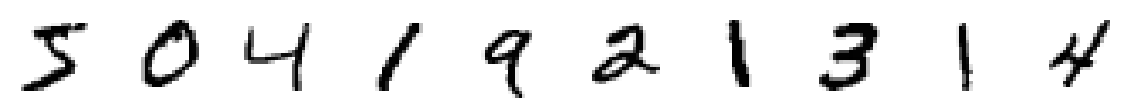

In [48]:
def draw(data, row, col, n):
  plt.subplot(row, col, n)
  plt.imshow(data, cmap=plt.cm.gray_r)
  plt.axis('off')


show_size = 10
plt.figure(figsize=(20,20))
for i in range(show_size):
  draw(X_train[i].reshape(28,28), 1, show_size, i+1)
plt.show()


In [0]:
get_first_layer_output = K.function([model.layers[0].input], [model.layers[1].output])
first_layer = get_first_layer_output([X_train[0:show_size]])[0]
plt.figure(figsize=(20,20))
print('first layer shape: ', first_layer.shape)
for img_index, filters in enumerate(first_layer, start=1):
 for filter_index, mat in enumerate(filters):
  pos = (filter_index)*10+img_index
  draw(mat, nb_filters, show_size, pos)
plt.tight_layout()
plt.show()